In [ ]:
# default_exp diff_analysis

In [ ]:
#export
from ms_empire.background_distributions import *
from ms_empire.diffquant_utils import *

In [ ]:
#export
from scipy.stats import norm
import numpy as np
import math
import statistics

class DifferentialIon():

    def __init__(self,noNanvals_from, noNanvals_to, diffDist, name, outlier_correction = True):
        self.usable = False
        self.name = name
        p_val, fc, z_val = calc_diffreg_peptide(noNanvals_from, noNanvals_to, diffDist, name, outlier_correction)
        if (p_val!=None):
            self.p_val=p_val
            self.fc=fc
            self.z_val = z_val
            self.usable = True

def calc_diffreg_peptide(noNanvals_from, noNanvals_to, diffDist, name, outlier_correction):
    weird_ions = ["FPEDLENDIR", "TMPGGNDHEIFTDPR", "TVVVVGTVTDDAR"] #DEBUG

    nrep_from = len(noNanvals_from)
    nrep_to = len(noNanvals_to)



    if ((nrep_from==0) or (nrep_to ==0)):
        return None, None, None
    var_from = diffDist.var_from
    var_to = diffDist.var_to

    perEvidenceVariance = diffDist.var + (nrep_to-1) * var_from + (nrep_from-1) * var_to
    totalVariance = perEvidenceVariance*nrep_to * nrep_from
    outlier_scaling_factor = 1.0
    if outlier_correction:
        outlier_scaling_factor = calc_outlier_scaling_factor(noNanvals_from, noNanvals_to, diffDist)

    fc_sum =0
    z_sum=0
    unscaled_zs = []
    fcs = []
    for from_intens in noNanvals_from:
        for to_intens in noNanvals_to:
            fc = from_intens - to_intens
            fcs.append(fc)
            fc_sum+=fc
            z_unscaled = diffDist.calc_zscore_from_fc(fc)
            unscaled_zs.append(z_unscaled)
            z_sum += z_unscaled/outlier_scaling_factor

    fc = fc_sum/(nrep_from * nrep_to)
    scaled_SD =  math.sqrt(totalVariance/diffDist.var)*outlier_scaling_factor
    p_val = 2.0 * (1.0 -  norm(loc=0, scale= scaled_SD).cdf(abs(z_sum)))
    z_val = z_sum/scaled_SD
    if name in weird_ions:
        fcs.sort()
        unscaled_zs.sort()
        print(name)
        print(f"fcs {fcs}")
        print(f"zvals {unscaled_zs}")
        print(f"BG SD {math.sqrt(diffDist.var)} pval {p_val} zval {z_val} total var {totalVariance} scaling factor {outlier_scaling_factor} scaled SD {scaled_SD} zsum {z_sum}")
    return p_val, fc, z_val

  #self.var_from = from_dist.var
   #     self.var_to

def calc_outlier_scaling_factor(noNanvals_from, noNanvals_to, diffDist):
    sd_from = math.sqrt(diffDist.var_from)
    sd_to = math.sqrt(diffDist.var_to)
    median_from = statistics.median(noNanvals_from)
    median_to = statistics.median(noNanvals_to)

    between_rep_SD_from = math.sqrt(sum(np.square(noNanvals_from-median_from))/len(noNanvals_from)) if len(noNanvals_from)>1 else sd_from
    between_rep_SD_to = math.sqrt(sum(np.square(noNanvals_to-median_to))/len(noNanvals_to)) if len(noNanvals_to)>1 else sd_to

    highest_SD_from = max(between_rep_SD_from, sd_from)
    highest_SD_to = max(between_rep_SD_to, sd_to)
    highest_SD_combined = math.sqrt(highest_SD_from**2 + highest_SD_to**2)

    scaling_factor = max(1.0, highest_SD_combined/diffDist.SD)
    return scaling_factor

In [ ]:
double calcedFromSD = (reps1.size() == 1) ? rep1error.SD : Math.sqrt(NumUtils.sum(map(reps1, (_d) -> Math.pow(repFromMean - _d, 2.0))) / reps1.size());
double calcedToSD = (reps2.size() == 1) ? rep2error.SD : Math.sqrt(NumUtils.sum(map(reps2, (_d) -> Math.pow(repToMean - _d, 2.0))) / reps2.size());

double corrSD1 = Math.max(rep1error.SD,  calcedFromSD);
double corrSD2 = Math.max(rep2error.SD,  calcedToSD);
double corrCombinedSD = Math.sqrt(Math.pow(corrSD1, 2.0) + Math.pow(corrSD2, 2.0));
sdCorrectionScale = Math.max(1.0, corrCombinedSD / diffErr.getSD());

In [ ]:
#export
import math
import statistics
from scipy.stats import norm
import numpy as np

class DifferentialProtein():

    def __init__(self, name, ion_diffresults, median_offset):
        self.name = name
        fc, pval, ions = self.evaluate_protein_expression(ion_diffresults, median_offset)
        self.pval=pval
        self.fc=fc
        self.ions = ions
        self.num_ions = len(ions)



    def evaluate_protein_expression(self, ion_diffresults, median_offset):
        ion_diffresults = list(filter(lambda _f : _f.usable, ion_diffresults))

        if len(ion_diffresults) ==0:
            return
        fcs = list(map(lambda _dr : _dr.fc,ion_diffresults))
        median_fc = np.median(fcs)


        ion_diffresults, median_offset_fc = self.select_robust_if_many_ions(fcs, median_fc,ion_diffresults)


        z_sum = sum(map(lambda _dr: _dr.z_val, ion_diffresults))
        p_val = 2.0 * (1.0 - norm(0, math.sqrt(len(ion_diffresults))).cdf(abs(z_sum)))
        ions = list(map(lambda _dr : _dr.name, ion_diffresults))

        prot_fc = median_offset_fc if median_offset else median_fc
        return median_offset_fc, p_val, ions


    def select_robust_if_many_ions(self, fcs, median_fc,ion_diffresults):
        ninety_perc_cutoff = math.ceil(0.9*len(ion_diffresults)) #the ceil function ensures that ions are only excluded if there are more than 10 available
        ion_diffresults = sorted(ion_diffresults, key = lambda _dr : abs(_dr.fc - median_fc))
        if ninety_perc_cutoff >0:
            ion_diffresults = ion_diffresults[:ninety_perc_cutoff]
        median_offset_fc = get_middle_elem(list(map(lambda _dr : _dr.fc,ion_diffresults)))
        return ion_diffresults, median_offset_fc

In [ ]:
#export
import numpy as np

def calc_pseudo_intensities(normed_df_c2, pep2prot, cond_prots, cond_fcs,condpair):
    summed_df = normed_df_c2.copy()
    numrep = len(normed_df_c2.columns)-1
    print(f"numrep {numrep}")
    display(normed_df_c2)
    summed_df["summed_int"] = normed_df_c2["median"]+numrep#summed_df.sum(axis=1)
    summed_df["summed_int"] = np.exp2(summed_df["summed_int"])
    summed_df = summed_df[["summed_int"]]
    summed_df["protein"] = list(map(lambda x: pep2prot.get(x),summed_df.index))
    summed_df = summed_df.reset_index()
    summed_df = summed_df.set_index(['protein', 'peptide'])
    summed_df = summed_df.sum(level='protein')
    prot2int = dict(zip(summed_df.index, summed_df["summed_int"]))
    pseudoint1 = list(map(lambda x : prot2int.get(x),cond_prots))*np.exp2(cond_fcs)
    pseudoint2 = list(map(lambda x : prot2int.get(x),cond_prots))
    return pseudoint1, pseudoint2

In [ ]:
import pandas as pd
num_vals = 10000
rand1 = np.random.normal(loc=0 ,size=num_vals)
rand2 = np.random.normal(loc=0, size=num_vals)
rand3 = np.random.normal(loc=0, size=num_vals)
rand4 = np.random.normal(loc=0, size=num_vals)
rand5 = np.random.normal(loc=0, size=num_vals)

randarray = pd.DataFrame({1:rand1, 2:rand2, 3:rand3, 4:rand4, 5:rand5})
#display(randarray)
condbg = ConditionBackgrounds(randarray)

In [ ]:
#hide
import numpy as np
def test_diffreg_pep(condbg, noNanvals_from, bg_idx1, noNanvals_to, bg_idx2):
    bgdist_from = condbg.backgrounds[bg_idx1]
    bgdist_to = condbg.backgrounds[bg_idx2]
    diffion = DifferentialIon(noNanvals_from, bgdist_from, noNanvals_to,bgdist_to)
    print(f"fc {diffion.fc}, pval {diffion.p_val}, zval {diffion.z_val} ")
    return diffion.p_val


noNanvals_from = np.array([1,2,1,2])
noNanvals_to = np.array([2.1,1.1,1.9,0.9])
bg_idx1 = np.random.randint(0, len(condbg.backgrounds))
bg_idx2 = np.random.randint(0, len(condbg.backgrounds))
test_diffreg_pep(condbg, noNanvals_from, 0, noNanvals_to, 1)

305034720793 
append
1183
931
69
fc -4.987701159695673, pval 0.6632016162758556, zval -0.43549713754798947 
append
709
925
1021
731
947
1043
823
1039
1135
fc 2.4465367860526177, pval 0.09824567054627709, zval -1.6534187447243687 
append
53
81
631
660
218
1010
fc -1.1216336518298506, pval 0.6740974822548265, zval 0.42053114479674547 
append
424
1023
921
194
793
690
1200
fc 2.857519253400781, pval 0.8022394306300109, zval 0.25044991760107865 
append
609
634
740
91
116
223
673
697
805
fc -1.7638363450850296, pval 0.567086901397484, zval 0.5723470190959834 
append
1160
1228
501
206
274
29
fc -1.9852665166017058, pval 0.9833801247611966, zval -0.020831431127274983 
append
971
928
1267
616
573
910
458
415
753
fc 0.7964108171577884, pval 0.7779176698010943, zval -0.28203370011116685 
append
456
809
1077
fc 7.454804511158094, pval 0.37715963971388966, zval 0.8831418415491715 
append
393
1078
1122
374
1059
1103
358
402
fc -0.681076809025288, pval 0.8078738011292081, zval -0.2431698771567278 
ap

(array([100.,  98.,  96.,  94.,  92.,  90.,  83.,  67.,  50.,  35.]),
 array([1.42774681e-13, 9.98399198e-02, 1.99679840e-01, 2.99519759e-01,
        3.99359679e-01, 4.99199599e-01, 5.99039519e-01, 6.98879438e-01,
        7.98719358e-01, 8.98559278e-01, 9.98399198e-01]),
 <a list of 10 Patch objects>)

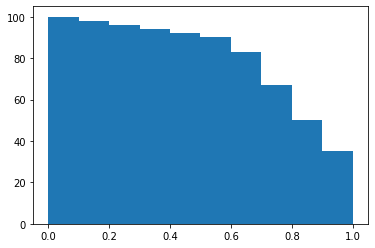

In [ ]:
#hide
from scipy.stats import norm
import random
import matplotlib.pyplot as plt

def test_noreg_pepdist(condbg, num_samplings):
    res = []
    bg_idxs = list(range(len(condbg.backgrounds)))

    for i in range(num_samplings):
        vals1 = 20+np.random.randn(3)*5
        vals2 =  20+np.random.randn(3)*5
        random.shuffle(bg_idxs)
        bg_idx1 = bg_idxs[0]
        bg_idx2 = bg_idxs[1]
        pval = test_diffreg_pep(condbg, vals1, 0, vals2, 1)
        print("append")
        res.append(pval)
    return res

pvals = test_noreg_pepdist(condbg, 100)


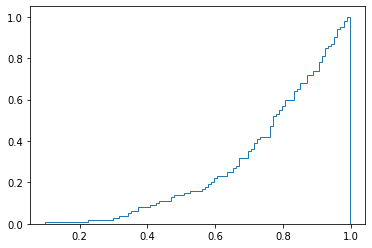

In [ ]:

plt.hist(pvals,99,cumulative=True,density=True, histtype='step')
plt.show()

In [ ]:
from scipy.stats import norm

norm.cdf(4.653643426357759)

0.9999983693971419